In [3]:
"""Compare the results within the average_first_pulse_fit_force_sign 
table and the average_first_pulse_fit_any_sign table.  The difference
is whether or not the sign of the fit amplitude is forced to the measured 
value.  This requires data saved into .csv files created from 
analyze_first_pulse_average.ipynb.  
"""
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook  
matplotlib.rcParams['figure.figsize'] = [8, 8]
# import mpld3
# mpld3.enable_notebook()


In [2]:
forced_df=pd.read_csv('average_fit_forced_sign_10_01_18.csv')  #data loaded from query above
any_df=pd.read_csv('average_fit_any_sign_10_01_18.csv')

In [4]:
#Merge the any sign versus forced sign data frames
merged_df = pd.merge(forced_df, any_df, on=['uid', 'pre_cell_id', 'post_cell_id', 
                                            'boolean_connection', 'distance', 
                                            'syn_excitation','measured_amp',
                                           'measured_baseline', 'n_sweeps'], how='inner', suffixes={'_f', '_a'})
merged_df['uid']=merged_df['uid'].astype(str)

# note that the length of the merged data frame equaling the len of the smallest 
# individual dataframe shows that the values being merged on are the same in the
# two databases.
print(len(forced_df))
print(len(any_df))
print(len(merged_df))
connected_df=merged_df[merged_df['boolean_connection']==True]

10713
10725
10713


<IPython.core.display.Javascript object>


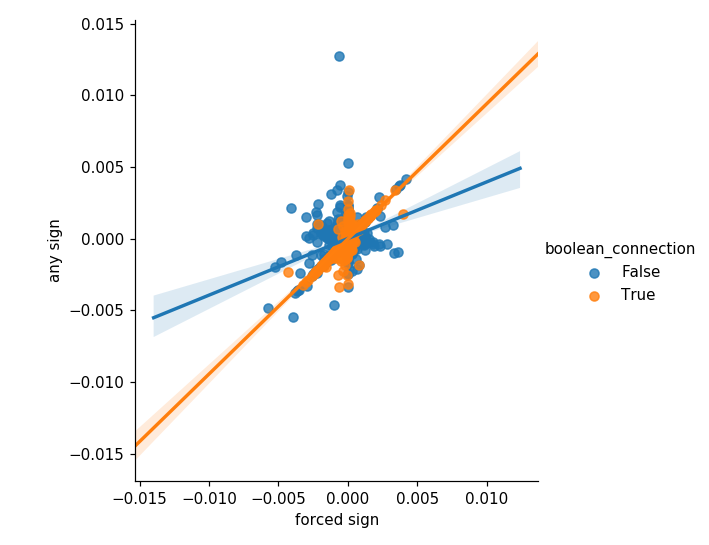

Text(57.642,0.5,'any sign')

In [5]:
#Check to see if relationships are linear
sns.lmplot(x="amp_f", y="amp_a", hue='boolean_connection', data=merged_df)
plt.xlabel('forced sign')
plt.ylabel('any sign')

875


<IPython.core.display.Javascript object>


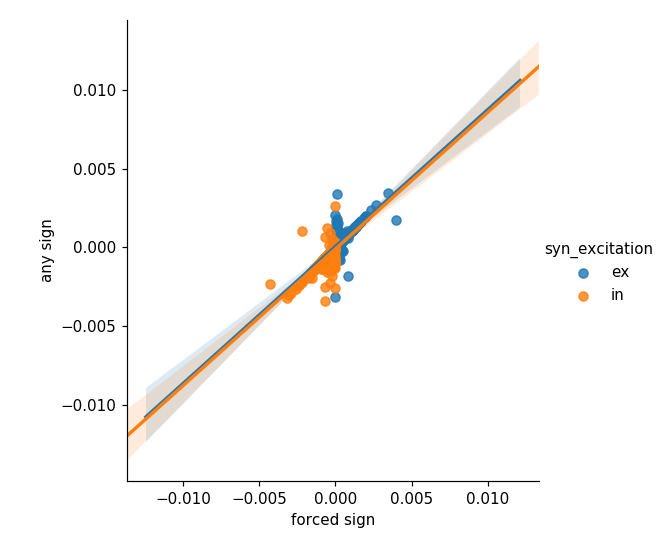

Text(50.2245,0.5,'any sign')

In [6]:
#Perhaps the ones that dont match well should be eliminated?
print(len(connected_df))
sns.lmplot(x="amp_f", y="amp_a", hue='syn_excitation', data=connected_df)
plt.xlabel('forced sign')
plt.ylabel('any sign')



In [ ]:
plt.figure()
sc=plt.scatter(x=connected_df["amp_f"], y=connected_df["amp_a"], c=connected_df['NRMSE_f'],  s=35, cmap='jet')
plt.colorbar(sc)
plt.xlabel('forced sign')
plt.ylabel('any sign')

In [7]:
def select_data(df, f_limits, a_limits):
    '''Select rows of a dataframe based on limits'''
    selected_df=df[(df["amp_f"]>f_limits[0]) & (df["amp_f"]<f_limits[1]) &
                   (df["amp_a"]>a_limits[0]) & (df["amp_a"]<a_limits[1])]
    return selected_df

s_df=select_data(connected_df, [-.4e-3, -.38e-3], [.12e-3, .14e-3])
print(s_df[["uid", "pre_cell_id", "post_cell_id", "latency_f", "latency_a", "n_sweeps"]])
s_df=select_data(connected_df, [-.21e-3, -.19e-3], [.54e-3, .57e-3])
print(s_df[["uid", "pre_cell_id", "post_cell_id", "latency_f", "latency_a", "n_sweeps"]])


                 uid  pre_cell_id  post_cell_id  latency_f     latency_a  \
2482  1522206462.105            8             7   0.003517  1.295042e-09   

      n_sweeps  
2482        40  
                 uid  pre_cell_id  post_cell_id  latency_f  latency_a  \
2623  1521665558.197            3             1   0.000687   0.002794   

      n_sweeps  
2623         7  


In [ ]:
s_df.keys()

In [ ]:
plt.figure()
sc=plt.scatter(x=connected_df["amp_f"], y=connected_df["amp_a"], c=connected_df['NRMSE_a'],  s=35, cmap='jet')
plt.colorbar(sc)
plt.xlabel('forced sign')
plt.ylabel('any sign')


In [42]:
# Create a new column called amp_close that specifies if the amplitude in FS and AS paradigms are close
def isclose(a, b, rel_tol=.5, abs_tol=0.0):
    '''Evaluates if two numbers are close on the order of the smallest 
    number.  math.close() uses the larges number'''
    return abs(a-b) <= np.maximum(rel_tol * np.minimum(abs(a), abs(b)), abs_tol)
c=connected_df.apply(lambda row: isclose(row.amp_a, row.amp_f), axis=1)
connected_df=connected_df.assign(amp_close=c.values)

# Create a new column d_from_amp_equal that specifies a combination of the distance 
# from the equality line and normalized by a distance from the origin with the idea
# that values closer to zero are small psps and so a difference between their values
# should be proportional to differences in larger values.
def distance(a, b):
    '''distance from line normalized by sqrt of distance from origin'''
    p=(b+a)/2.  #x and y coordinates (since x=y) of point on line closest to data point 
    d_from_line=np.sqrt((p-a)**2 + (p-b)**2)  #distance of a point to the unity line
    d_from_origin=np.sqrt(a**2 + b**2) #distance to the origin
    return d_from_line/np.sqrt(d_from_origin) #normalized by sqrt of the distance from orgin

connected_df['d_from_amp_equal']=connected_df.apply(lambda row: distance(row.amp_a, row.amp_f), axis=1)

<IPython.core.display.Javascript object>


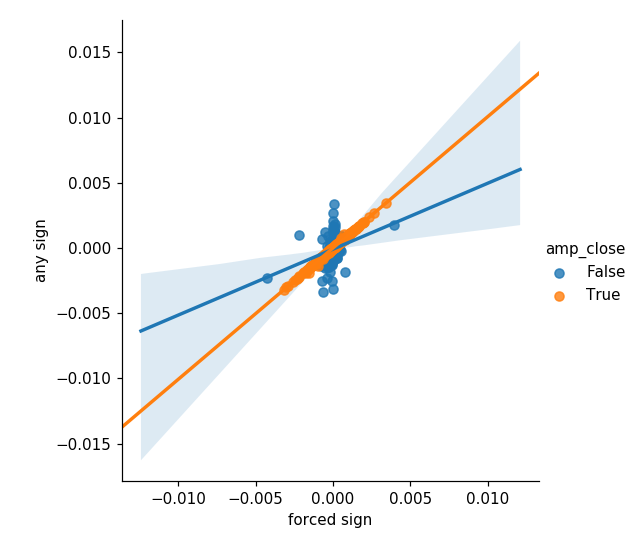

Text(45.4301,0.5,'any sign')

In [44]:
sns.lmplot(x="amp_f", y="amp_a", hue="amp_close", data=connected_df)
plt.xlabel('forced sign')
plt.ylabel('any sign')

<IPython.core.display.Javascript object>


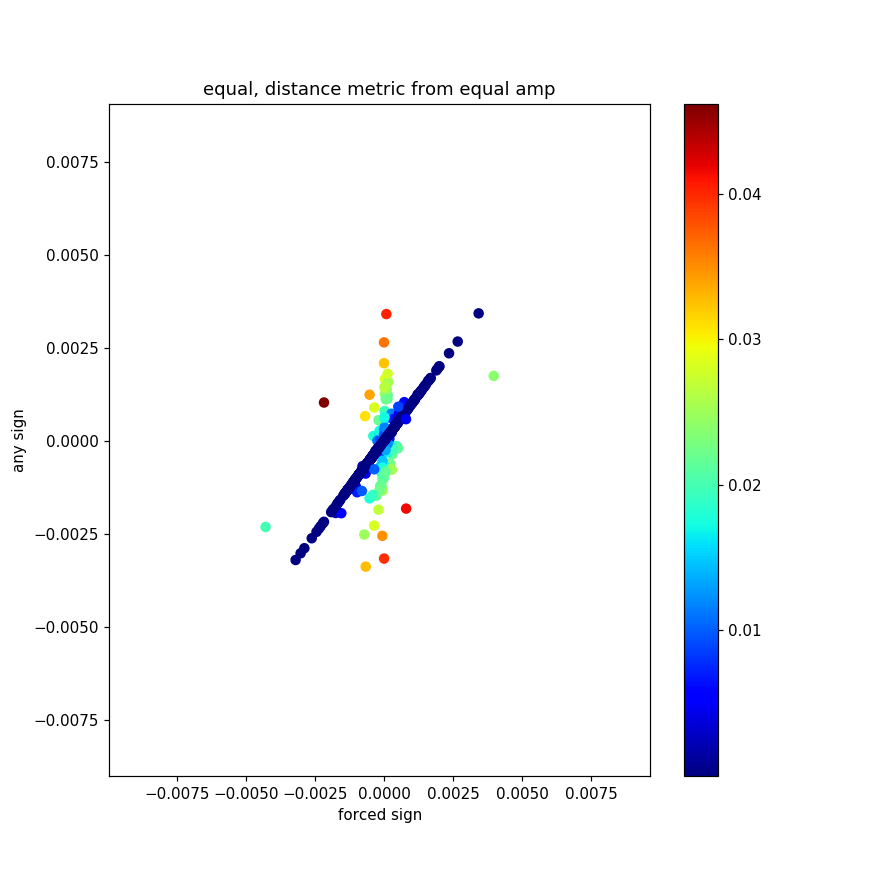

Text(0.5,1,'equal, distance metric from equal amp')

In [45]:
plt.figure()
sc=plt.scatter(x=connected_df["amp_f"], y=connected_df["amp_a"], c=connected_df['d_from_amp_equal'],  s=35, cmap='jet')
plt.colorbar(sc)
plt.xlabel('forced sign')
plt.ylabel('any sign')
plt.title('equal, distance metric from equal amp')


In [51]:
# now lets sort by the distance metric
connected_df.sort_values(by=['d_from_amp_equal'])[['uid','pre_cell_id', 'post_cell_id', 'amp_f', 
                                                   'amp_a', 'latency_f', 'latency_a',
                                                   'NRMSE_a', 'NRMSE_f','d_from_amp_equal']]

,uid,pre_cell_id,post_cell_id,amp_f,amp_a,latency_f,latency_a,NRMSE_a,NRMSE_f,d_from_amp_equal
8618,1491587831.024,8,3,-6.642461e-04,-0.000664,1.041661e-03,1.041661e-03,0.747883,0.747883,2.280552e-11
8535,1492018873.073,8,4,-1.415639e-03,-0.001416,1.729071e-03,1.729071e-03,0.265508,0.265508,3.552184e-11
3729,1517356063.393,3,6,-4.251717e-04,-0.000425,6.917611e-04,6.917596e-04,1.371013,1.371013,4.072766e-11
5459,1507690323.707,3,5,1.508949e-04,0.000151,1.287889e-03,1.287913e-03,1.713421,1.713421,5.446584e-11
8645,1491431565.2879999,3,2,-3.212483e-04,-0.000321,1.607408e-03,1.607403e-03,1.844648,1.844648,5.860368e-11
3771,1517269966.8579998,2,8,-1.611224e-03,-0.001611,9.685019e-04,9.685019e-04,0.302998,0.302998,1.220448e-10
1687,1525466880.9589999,8,1,2.842186e-04,0.000284,1.240960e-03,1.240960e-03,0.963428,0.963428,1.562790e-10
2550,1522103772.718,6,8,-2.984338e-04,-0.000298,1.554037e-03,1.554035e-03,1.513828,1.513828,2.157734e-10
5884,1504300627.314,8,2,-5.978912e-04,-0.000598,1.197356e-03,1.197356e-03,0.369624,0.369624,2.356942e-10
1629,1525731951.02,2,8,-9.214130e-04,-0.000921,1.254563e-03,1.254563e-03,0.724194,0.724194,2.844581e-10


In [52]:
connected_df.sort_values(by=['d_from_amp_equal'])[[ 'NRMSE_f']]

,NRMSE_f
8618,0.747883
8535,0.265508
3729,1.371013
5459,1.713421
8645,1.844648
3771,0.302998
1687,0.963428
2550,1.513828
5884,0.369624
1629,0.724194


In [ ]:
connected_and_eq=connected_df[connected_df['amp_close']==True]
connected_and_uneq=connected_df[connected_df['amp_close']==False]

In [ ]:
plt.figure()
sc=plt.scatter(x=connected_and_eq["amp_f"], y=connected_and_eq["amp_a"], c=connected_and_eq['NRMSE_f'],  s=35, cmap='jet')
plt.colorbar(sc)
plt.xlabel('forced sign')
plt.ylabel('any sign')
plt.title('equal, forced NRMSE')

In [ ]:
plt.figure()
sc=plt.scatter(x=connected_and_uneq["amp_f"], y=connected_and_uneq["amp_a"], c=connected_and_uneq['NRMSE_f'],  s=35, cmap='jet')
plt.colorbar(sc)
plt.xlabel('forced sign')
plt.ylabel('any sign')
plt.title('unequal, forced NRMSE')

In [ ]:
print(len(connected_and_eq))
print(len(connected_and_uneq))

In [ ]:
df=connected_and_eq[['uid','pre_cell_id', 'post_cell_id', 'amp_x', 'amp_y']]

In [ ]:
df.sort_values('uid')

In [ ]:
df=merged_df[merged_df['boolean_connection']==False]
plt.plot(df['amp_x'], df['amp_y'], '.')